In [1]:
import librosa
import soundfile
import os
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Model
from keras.layers import (
    Conv1D,
    Activation,
    Dropout,
    MaxPooling1D,
    Flatten,
    Dense,
    Input,
)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
# Function to recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


# Base path for TESS dataset
base_path_TESS = "../data/raw/TESS_Toronto_emotional_speech_set_data"

# Get all audio files from TESS datasets
audio_files_tess = get_audio_files(base_path_TESS)
# Save audio files paths
if not os.path.exists("../data/processed/audio_files_tess.txt"):
    with open("../data/processed/audio_files_tess.txt", "w") as f:
        for item in audio_files_tess:
            f.write("%s\n" % item)
    print("../data/processed/audio_files_tess.txt already exists is created")
else:
    print("../data/processed/audio_files_tess.txt already exists")

../data/processed/audio_files_tess.txt already exists


In [3]:
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(
    file_path,
    include_mfcc=True,
    include_chroma=True,
    include_mel=True,
    include_contrast=True,
    sample_rate=22050,
):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        features = []

        if include_mfcc:
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
            features.append(np.mean(mfccs, axis=1))

        if include_chroma:
            chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
            features.append(np.mean(chroma, axis=1))

        if include_mel:
            mel = librosa.feature.melspectrogram(y=audio, sr=sr)
            features.append(np.mean(mel, axis=1))

        if include_contrast:
            contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
            features.append(np.mean(contrast, axis=1))

        return np.hstack(features)
    except Exception:
        print(f"Error encountered while parsing file: {file_path}")
        return None


# Load audio files from the text file
audio_files_tess = []
with open("../data/processed/audio_files_tess.txt", "r") as file:
    audio_files_tess = [line.strip() for line in file.readlines()]


# Function to create datasets excluding one feature each time
def create_datasets():
    features_labels = []

    feature_sets = {
        "all_features": (True, True, True, True),
        "no_mfcc": (False, True, True, True),
        "no_chroma": (True, False, True, True),
        "no_mel": (True, True, False, True),
        "no_contrast": (True, True, True, False),
    }
    

    for set_name, (mfcc, chroma, mel, contrast) in feature_sets.items():
        features = []
        labels = []
        label_map_tess = {
            "OAF_angry": 4,
            "OAF_disgust": 6,
            "OAF_Fear": 5,
            "OAF_happy": 2,
            "OAF_Pleasant_surprise": 7,
            "OAF_Sad": 3,
            "OAF_neutral": 0,
            "YAF_angry": 4,
            "YAF_disgust": 6,
            "YAF_fear": 5,
            "YAF_happy": 2,
            "YAF_pleasant_surprised": 7,
            "YAF_sad": 3,
            "YAF_neutral": 0,
        }
        label_map_ravdess = {
            "01": 0,
            "02": 1,
            "03": 2,
            "04": 3,
            "05": 4,
            "06": 5,
            "07": 6,
            "08": 7,
        }
        for idx, file in enumerate(audio_files_tess, start=1):
            feature = extract_features(
                file,
                include_mfcc=mfcc,
                include_chroma=chroma,
                include_mel=mel,
                include_contrast=contrast,
            )
            if feature is not None:
                features.append(feature)
                if "audio_speech_actors_01-24" in file:
                    # Extract label from RAVDESS file name
                    label = file.split(os.sep)[-1].split("-")[2]
                    labels.append(label_map_ravdess[label])
                else:
                    # Extract label from TESS file path
                    emotion = file.split(os.sep)[-2]
                    if emotion in label_map_tess:
                        labels.append(label_map_tess[emotion])
                    else:
                        print(f"Skipping {file} with unrecognized emotion: {emotion}")
                        features.pop()  # Remove the feature if label is not recognized
            print(
                f"Processing file {idx} of {len(audio_files_tess)} for set {set_name}"
            )

        features = np.array(features)
        labels = np.array(labels)
        features_labels.append((features, labels, set_name))

    return features_labels


# Create and save datasets
if not os.path.exists("../data/processed/features_labels_datasets.npy"):
    datasets = create_datasets()
    np.save("../data/processed/features_labels_datasets.npy", datasets)
else:
    datasets = np.load(
        "../data/processed/features_labels_datasets.npy", allow_pickle=True
    )
    print("Datasets loaded")

Processing file 1 of 2800 for set all_features
Processing file 2 of 2800 for set all_features
Processing file 3 of 2800 for set all_features
Processing file 4 of 2800 for set all_features
Processing file 5 of 2800 for set all_features
Processing file 6 of 2800 for set all_features
Processing file 7 of 2800 for set all_features
Processing file 8 of 2800 for set all_features
Processing file 9 of 2800 for set all_features
Processing file 10 of 2800 for set all_features
Processing file 11 of 2800 for set all_features
Processing file 12 of 2800 for set all_features
Processing file 13 of 2800 for set all_features
Processing file 14 of 2800 for set all_features
Processing file 15 of 2800 for set all_features
Processing file 16 of 2800 for set all_features
Processing file 17 of 2800 for set all_features
Processing file 18 of 2800 for set all_features
Processing file 19 of 2800 for set all_features
Processing file 20 of 2800 for set all_features
Processing file 21 of 2800 for set all_features
P

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 3) + inhomogeneous part.

Training and evaluating for feature set: all_features
Epoch 1/50


c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4557 - loss: 3.5917 - val_accuracy: 0.9089 - val_loss: 0.3503
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8868 - loss: 0.3279 - val_accuracy: 0.9518 - val_loss: 0.1818
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9475 - loss: 0.1641 - val_accuracy: 0.9750 - val_loss: 0.1144
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9725 - loss: 0.0900 - val_accuracy: 0.9839 - val_loss: 0.0754
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9810 - loss: 0.0638 - val_accuracy: 0.9571 - val_loss: 0.1852
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9732 - loss: 0.0833 - val_accuracy: 0.9875 - val_loss: 0.0550
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9838 - loss: 0.0480 - val_accuracy: 0.9857 - val_loss: 0.0393
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9870 - loss: 0.0426 - val_accuracy: 0.9589 - val_loss: 0.1341
Ep

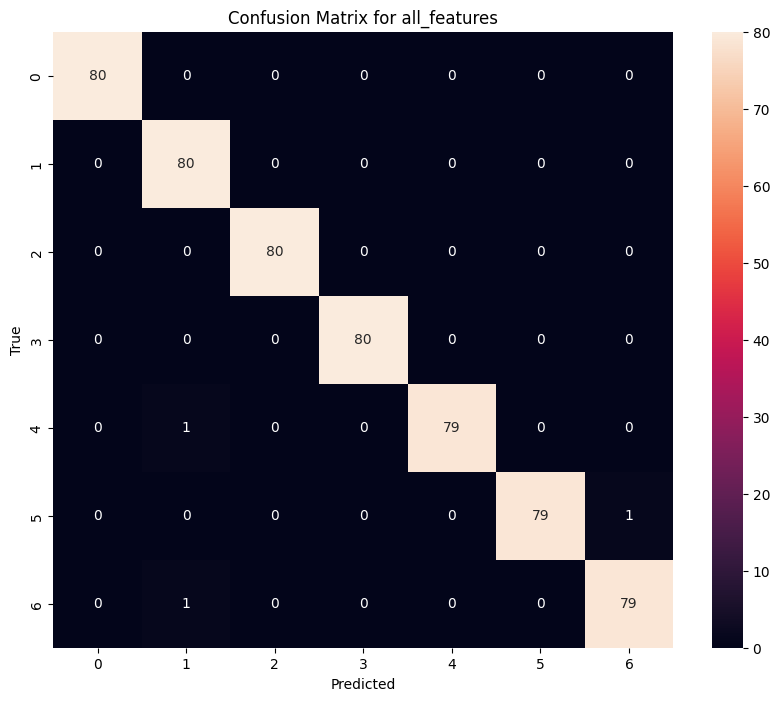

Training and evaluating for feature set: no_mfcc
Epoch 1/50


c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3879 - loss: 1.7470 - val_accuracy: 0.5964 - val_loss: 1.5827
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7295 - loss: 0.8887 - val_accuracy: 0.8429 - val_loss: 0.5632
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8467 - loss: 0.4754 - val_accuracy: 0.8625 - val_loss: 0.3976
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8651 - loss: 0.3496 - val_accuracy: 0.8643 - val_loss: 0.4286
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9104 - loss: 0.2657 - val_accuracy: 0.9250 - val_loss: 0.2657
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9380 - loss: 0.1802 - val_accuracy: 0.9446 - val_loss: 0.2323
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9525 - loss: 0.1555 - val_accuracy: 0.9446 - val_loss: 0.1786
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9576 - loss: 0.1113 - val_accuracy: 0.9589 - val_loss: 0.1401
Ep

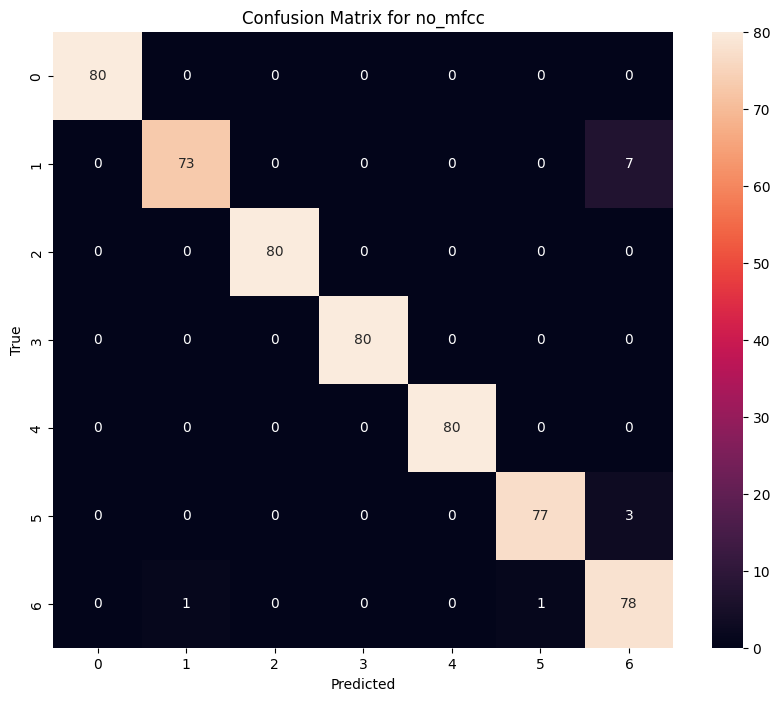

Training and evaluating for feature set: no_chroma
Epoch 1/50


c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4554 - loss: 4.1309 - val_accuracy: 0.9518 - val_loss: 0.2420
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9000 - loss: 0.3041 - val_accuracy: 0.9679 - val_loss: 0.1163
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9503 - loss: 0.1658 - val_accuracy: 0.9518 - val_loss: 0.1309
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9634 - loss: 0.0901 - val_accuracy: 0.9786 - val_loss: 0.0596
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9798 - loss: 0.0614 - val_accuracy: 0.9857 - val_loss: 0.0467
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9791 - loss: 0.0557 - val_accuracy: 0.9875 - val_loss: 0.0442
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0548 - val_accuracy: 0.9911 - val_loss: 0.0310
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9926 - loss: 0.0233 - val_accuracy: 0.9875 - val_loss: 0.0345
Ep

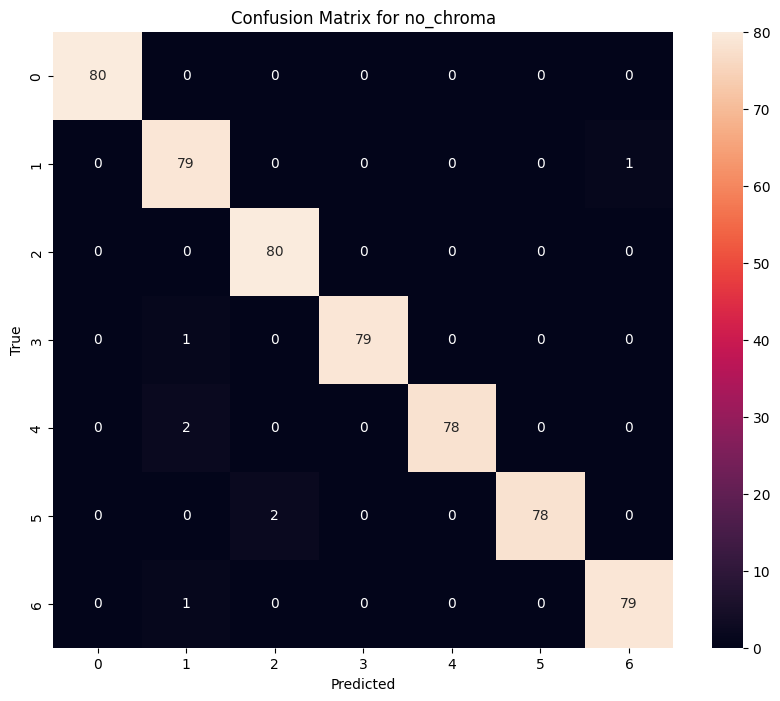

Training and evaluating for feature set: no_mel
Epoch 1/50


c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3899 - loss: 8.4317 - val_accuracy: 0.8321 - val_loss: 0.4492
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8588 - loss: 0.4146 - val_accuracy: 0.9625 - val_loss: 0.1360
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9409 - loss: 0.2093 - val_accuracy: 0.9571 - val_loss: 0.1323
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9440 - loss: 0.1575 - val_accuracy: 0.9821 - val_loss: 0.0614
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9710 - loss: 0.0943 - val_accuracy: 0.9571 - val_loss: 0.1342
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9725 - loss: 0.0828 - val_accuracy: 0.9696 - val_loss: 0.0839
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9780 - loss: 0.0645 - val_accuracy: 0.9821 - val_loss: 0.0418
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9734 - loss: 0.0907 - val_accuracy: 0.9732 - val_loss: 0.0691
Epo

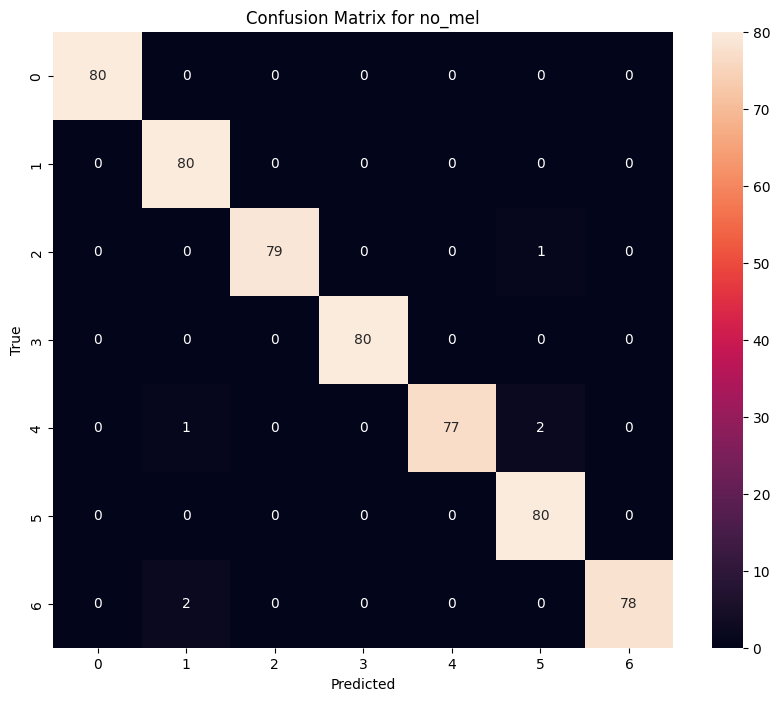

Training and evaluating for feature set: no_contrast
Epoch 1/50


c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4675 - loss: 3.9704 - val_accuracy: 0.8679 - val_loss: 0.4046
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9117 - loss: 0.3039 - val_accuracy: 0.8857 - val_loss: 0.3237
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9428 - loss: 0.1635 - val_accuracy: 0.9607 - val_loss: 0.1297
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9639 - loss: 0.1165 - val_accuracy: 0.9643 - val_loss: 0.1221
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9737 - loss: 0.0843 - val_accuracy: 0.9607 - val_loss: 0.1214
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9763 - loss: 0.0730 - val_accuracy: 0.9643 - val_loss: 0.0993
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9711 - loss: 0.0650 - val_accuracy: 0.9857 - val_loss: 0.0297
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9892 - loss: 0.0442 - val_accuracy: 0.9804 - val_loss: 0.0653
E

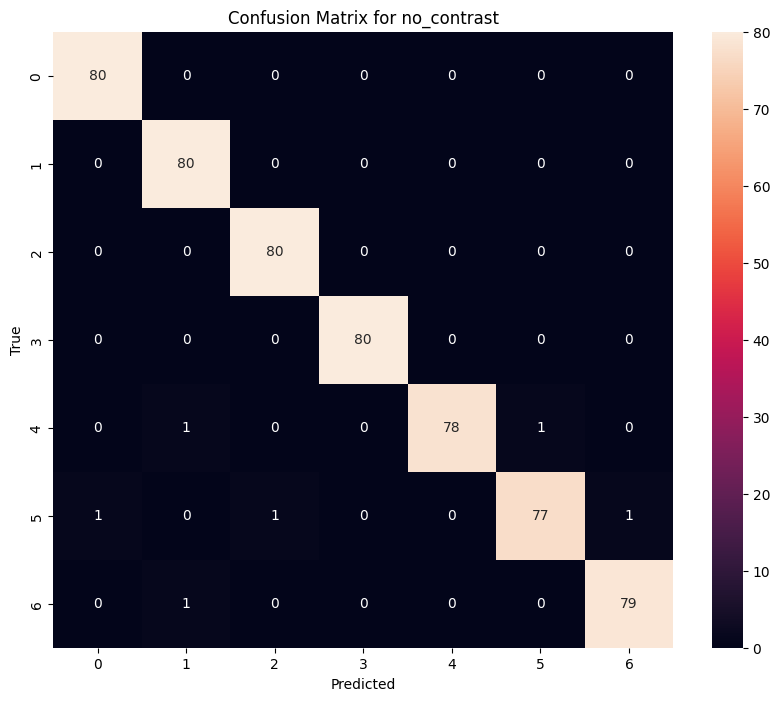

In [4]:
# Function to train and evaluate the model for each dataset
def train_evaluate_model(features, labels, set_name):
    print(f"Training and evaluating for feature set: {set_name}")
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Reshape data to fit the model: (num_samples, timesteps, num_features)
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    # Initialize a sequential model
    model = Sequential()

    # First convolutional layer with 64 filters, kernel size 5, 'same' padding, and ReLU activation
    model.add(
        Conv1D(64, 5, padding="same", input_shape=(X_train.shape[1], X_train.shape[2]))
    )
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=4))

    # Second convolutional layer with 128 filters, kernel size 5, 'same' padding, and ReLU activation
    model.add(Conv1D(128, 5, padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=4))

    # Third convolutional layer with 256 filters, kernel size 5, 'same' padding, and ReLU activation
    model.add(Conv1D(256, 5, padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))

    # Flatten the output for the dense layer
    model.add(Flatten())

    # Dense layer with 8 units and softmax activation for multi-class classification
    model.add(Dense(8))
    model.add(Activation("softmax"))

    # Define the RMSprop optimizer with a lower learning rate
    opt = RMSprop(learning_rate=0.001)

    # Compile the model with categorical crossentropy loss and the defined optimizer
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
    )

    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy for {set_name}: {score[1]}")

    # Generate classification report and confusion matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_test, y_pred_classes))

    # Plot confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sn.heatmap(confusion_mtx, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {set_name}")
    plt.show()


# Train and evaluate the model for each dataset
for features, labels, set_name in datasets:
    train_evaluate_model(features, labels, set_name)